# LMS Exploration | 11. Pneumonia_Classification

---

**[Introduce]**  
폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만들어봅시다.  


**[Data]**  
* 캐글의 Chest X-Ray Images
* X-ray 이미지 (JPEG) : 5,856 개
* 폐렴/정상 2개의 범주 
* 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아의 흉부 X선 영상

```python
X-ray는 전자기파가 몸을 통과하고 남은 결과이기 때문에 흑백 명암으로 나타나게 됩니다.  
    갈비뼈 : 하얀색
    폐 : 검은색
    어깨 쪽의 지방 및 근육 : 연한 회색 
        
폐렴의 경우 X-ray 사진 상, 다양한 양상의 음영(폐 부위의 희미한 그림자) 증가가 관찰됩니다. 
```

## 라이브러리 및 패키지 불러오기 

```Python 
! mkdir -p ~/aiffel/chest_xray
! ln -s ~/data/ ~/aiffel/chest_xray
```

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import requests

# 1. 실험환경 Set-up 

In [35]:
#- 데이터 로드 시 빠르게 로드할 수 있도록 설정하는 변수 

AUTOTUNE = tf.data.experimental.AUTOTUNE

#- X-RAY 이미지 사이즈 변수

IMAGE_SIZE = [180, 180]

#- 데이터 경로 변수

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)
print(VAL_PATH)

/aiffel/aiffel
/aiffel/aiffel/chest_xray/data/val/*/*


# 2. 데이터 준비하기

## 데이터 가져오기
데이터는 train, val(validation), test 로 나눠져 있습니다. 

In [7]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


val 개수가 너무 없기 때문에 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할합니다. 

In [8]:
#- train 데이터와 validation 데이터를 모두 filenames 에 담는다

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#- 모아진 filenames를 8: 2로 나눈다. 
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))


4185
1047


In [9]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[4000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person314_bacteria_1461.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person543_bacteria_2284.jpeg


In [10]:
#- 정상 이미지 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

#- 폐렴 이미지 세기
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"PNEUMONIA images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1107
PNEUMONIA images count in training set: 3078


* 정상보다 폐렴 이미지 수가 3배 많이 있습니다.  
CNN 모델의 경우 데이터가 클래스별 balance 가 좋을 수록 training이 잘 되기 때문에,  데이터가 클래스 불균형(imbalance)한 것은 뒤에서 보정해주겠습니다. 
 

* tf.data 인스턴스를 생성합니다.  
tf.data는 tensorflow 에서 학습시킬 때 배치처리 작업을 보다 효율적으로 할 수 있게 도와줍니다.   

### train dataset 만들기

In [11]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [13]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [14]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [15]:
#- train dataset과 validation dataset 만들기
#- num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 좌우반전 augmentation 도입

In [20]:
#- 좌우반전 augmentation 도입 
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [22]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [ True False  True  True  True False False False  True  True  True  True
  True  True False  True]


### test dataset 만들기

In [23]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


```python
for i in parameters['batch_size']:
    globals()['test_ds_batch{}'.format(i)] = test_ds.batch(i)
print(test_ds_batch32)
print(TEST_IMAGE_COUNT)
```

* tensorflow는 tf.data 파이프라인을 사용해서 학습데이터를 효율적으로 사용할 수 있게 해줍니다.
* prepare_for_training()은 학습 데이터를 효율적으로 할 수 있는 데이터를 변환시켜줍니다.
* shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
* 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 되는데, repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
* 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## 데이터 시각화 
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출하여,
추출된 배치를 image와 label 데이터 셋으로 나눕니다.


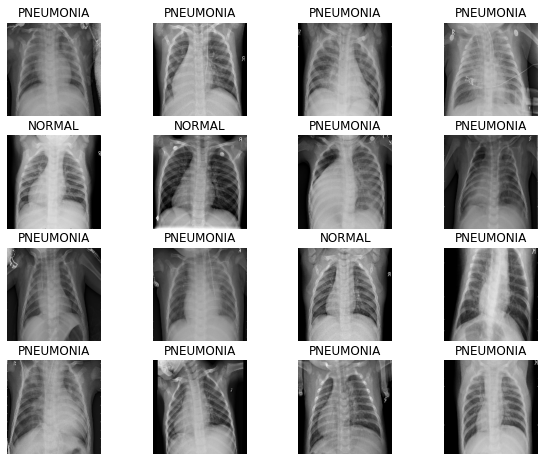

In [24]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 3. CNN 모델링 및 학습

좌우반전 augmentation이 적용된 dataset을 3가지 경우의 모델에 적용해보겠습니다.  
```python
1. Batch Normalization과 Dropout이라는 두 가지 regularization 기법 동시에 사용
2. 위 모델 구성을 그대로 하되, Dense_layer 직전 Conv_layer뒤에오는 Dropout 레이어의 Drop out 비율을 높이기
3. Only  Dropout without Batch Normalization- batch Normalization 제거
4. Only Batch Normalization without Dropout- conv_block 의 Dropout layer 제거
```

### 1. Batch Normalization과 Dropout 동시에 사용

```python
Accuracy: 0.8493589758872986,
Precision: 0.8162392973899841,
Recall: 0.9794871807098389
```

In [59]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


In [60]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [61]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.89
Weight for PNEUMONIA: 0.68


In [62]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

```python
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )
```

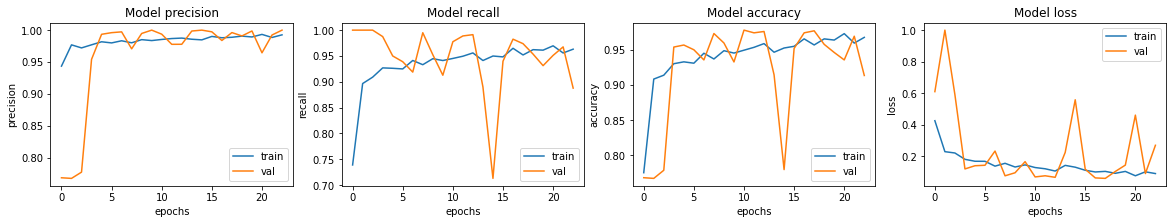

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.7476 - accuracy: 0.8462 - precision: 0.8403 - recall: 0.9308
Loss: 0.747552752494812,
Accuracy: 0.8461538553237915,
Precision: 0.8402777910232544,
Recall: 0.9307692050933838


### 2. Drop out 비율 높이기
위 모델 구성을 그대로 하되, Dense_layer 직전 Conv_layer뒤에오는 Dropout 레이어의 Drop out 비율을 높이기 drop out 0.2 -> 0.5  

```python
Loss: 0.46679845452308655,
Accuracy: 0.8541666865348816,
Precision: 0.8344519138336182,
Recall: 0.9564102292060852
```

In [49]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

```python
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )
```

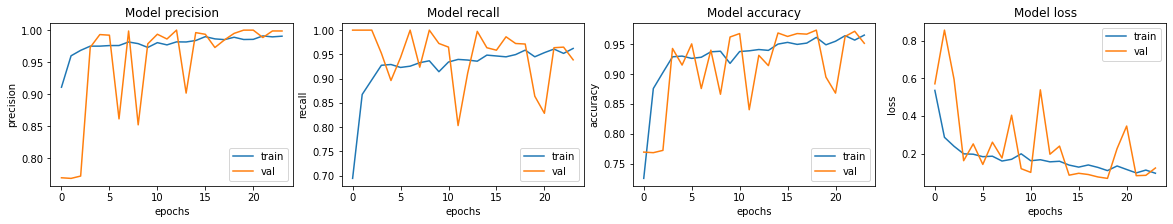

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 0.4668 - accuracy: 0.8542 - precision: 0.8345 - recall: 0.9564
Loss: 0.46679845452308655,
Accuracy: 0.8541666865348816,
Precision: 0.8344519138336182,
Recall: 0.9564102292060852


### 3. Only  Dropout without Batch Normalization 
batch Normalization 제거

```python
Loss: 0.6979788541793823,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0
```

In [54]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [55]:
with tf.device('/GPU:0'):
    model = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

```python
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )
```

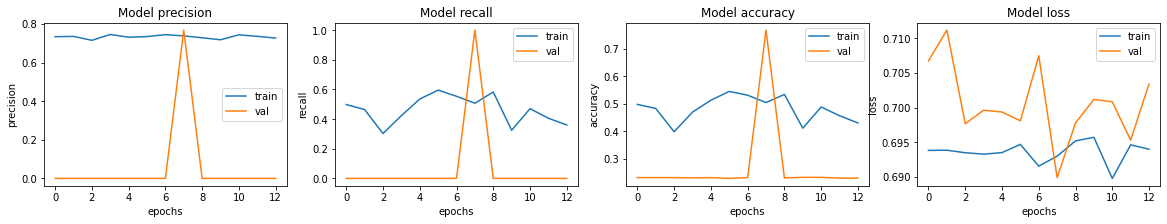

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [58]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 0.6980 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6979788541793823,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


### 4. Only Batch Normalization without Dropout
conv_block 의 Dropout layer 제거

```python
Loss: 0.3505326211452484,
Accuracy: 0.879807710647583,
Precision: 0.8987341523170471,
Recall: 0.9102563858032227
```

In [68]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
    ])
    
    return block



def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        
        conv_block(256),
        
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [71]:
with tf.device('/GPU:0'):
    model = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

```python
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )
```

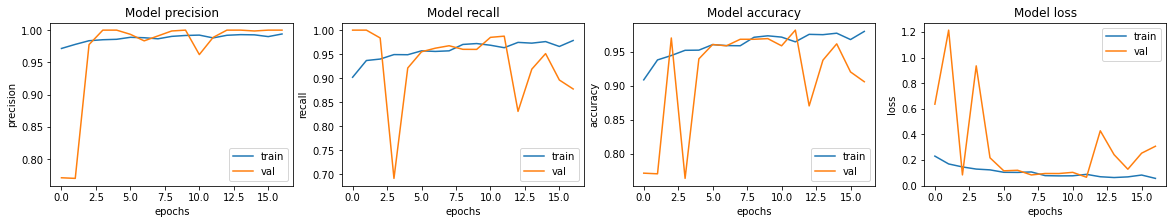

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [74]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.3505 - accuracy: 0.8798 - precision: 0.8987 - recall: 0.9103
Loss: 0.3505326211452484,
Accuracy: 0.879807710647583,
Precision: 0.8987341523170471,
Recall: 0.9102563858032227


# 4. 결과 확인


### model1. Batch Normalization과 Dropout 동시에 사용

    early stopping X  
    Accuracy: 0.8493589758872986,
    Precision: 0.8162392973899841,
    Recall: 0.9794871807098389

이 이후로는 early stopping 도입


    Loss: 0.747552752494812,
    Accuracy: 0.8461538553237915,
    Precision: 0.8402777910232544,
    Recall: 0.9307692050933838

### model2. Drop out 비율 높이기

    Loss: 0.46679845452308655,
    Accuracy: 0.8541666865348816,
    Precision: 0.8344519138336182,
    Recall: 0.9564102292060852

### model3. Only Dropout without Batch Normalization
batch Normalization 제거

    Loss: 0.6979788541793823,
    Accuracy: 0.375,
    Precision: 0.0,
    Recall: 0.0

### model4. Only Batch Normalization without Dropout
conv_block 의 Dropout layer 제거

    Loss: 0.3505326211452484,
    Accuracy: 0.879807710647583,
    Precision: 0.8987341523170471,
    Recall: 0.9102563858032227

---


model2에서 Drop out의 비율을 높였더니, Accuracy가 85%를 (간신히) 넘었다.   
batch Normalization을 제거하고 Dropout만 사용한 model3의 성능은 형편없었다. 반면 model4에서 conv_block에서의 Dropout은 제거한 경우, 87% 의 정확도를 보였다.  

다만, 우리가 예측하고자 하는 것은 '폐렴의 유무'이므로,   
양성을 음성으로 오진하지 않는 것이 중요하여 recall 값에 주목해야 한다.  


때문에 accuracy 87%, recall 91% 인 model4 보다 **accuracy 85.4%, recall 95%** 인 **model2** 가 성능이 좋다고 판단할 수 있다. 